In [ ]:
!wget https://raw.githubusercontent.com/huangwl18/ReKep/refs/heads/main/transform_utils.py

--2026-02-18 04:53:42--  https://raw.githubusercontent.com/huangwl18/ReKep/refs/heads/main/transform_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38253 (37K) [text/plain]
Saving to: ‘transform_utils.py’

transform_utils.py  100%[===================>]  37.36K  --.-KB/s    in 0.01s   

2026-02-18 04:53:43 (2.81 MB/s) - ‘transform_utils.py’ saved [38253/38253]



Let
* $T_r$ be the hardware camera pose in world frame
* $T_s$ be the software camera pose in world frame
* $T_c$ is the transform (error) between $T_r$ and $T_s$. That is, $T_r = T_s T_c$
* $T_m$ be the mark pose in world frame
* $T_r^*$ be the ideal pose that face $T_m$. So $T^*_r T_{m\to r^*} = T_m$, there $T_{m\to r^*}$ is a defined fixed transform between hardware camera and mark.
* $T_o$ be the transform that make $T_r$ transforms to $T_r^*$. That is, $T^*_r = T_s T_c T_o$
* In the iterative algorithm, superscript with bracket means iteration number. For example $T_r^{(n)}$ means the hardware camera pose in $n$-th iteration.

I have found that
\begin{align}
& T_o = T_{m\to r} (T_{m\to r^*})^{-1} = (T_r)^{-1}T_m [(T^*_r)^{-1}T_m]^{-1} = (T_r)^{-1}T_r^* \\
& T^{(n+1)}_r = T_s^{(n)} T_o^{(n)} T_c = T^{(n)}_r (T_c)^{-1} T_o^{(n)} T_c = T^{(0)}_r (T_c)^{-1} [\prod^n_{i=0} T_o^{(i)}] T_c \\
& T^*_r = T_s^{(0)} T_c T_o^{(0)} \\
\end{align}

$T_r^{(n+1)} = T_r^{(n)}$ iff $T^{(n)}_r = T^*_r$

# Import and functions

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import transform_utils as T
import cv2

def quat2mat(pose):
  pose = np.array(pose)
  t = pose[:3]
  q = pose[3:]
  rot_mat = Rotation.from_quat(q).as_matrix()
  mat = np.eye(4)
  mat[:3, :3] = rot_mat
  mat[:3, 3] = t
  return mat

def mat2quat(pose):
  q = Rotation.from_matrix(pose[:3, :3]).as_quat()
  t = pose[:3, 3]
  return np.concatenate([t, q], axis=0)

def random_pose():
  t = np.random.randn(3)
  rotvec = np.random.randn(3)
  q = Rotation.from_rotvec(rotvec).as_quat()
  pose = np.concatenate([t, q], axis=0)
  return quat2mat(pose)

def show_pose(ax, pose, name=None):
  pose = mat2quat(pose)

  # show position
  ax.scatter(pose[0], pose[1], pose[2])
  # show rotation
  rot_mat = Rotation.from_quat(pose[3:]).as_matrix()

  # Define basis vectors (x, y, z axes)
  basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

  # Transform basis vectors by rotation matrix
  rotated_basis = rot_mat @ basis_vectors.T

  # Plot arrows for the rotated axes
  origin = pose[:3]
  ax.quiver(origin[0], origin[1], origin[2],
            rotated_basis[0, 0], rotated_basis[1, 0], rotated_basis[2, 0], color='r', length=0.5, arrow_length_ratio=0.2)
  ax.quiver(origin[0], origin[1], origin[2],
            rotated_basis[0, 1], rotated_basis[1, 1], rotated_basis[2, 1], color='g', length=0.5, arrow_length_ratio=0.2)
  ax.quiver(origin[0], origin[1], origin[2],
            rotated_basis[0, 2], rotated_basis[1, 2], rotated_basis[2, 2], color='b', length=0.5, arrow_length_ratio=0.2)

  # Show name if provided
  if name is not None:
    ax.text(origin[0], origin[1], origin[2], name, fontsize=10, color='black')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('3D Pose Visualization')
  ax.set_aspect('auto')
  # Set limits to make sure the arrows are visible
  ax.set_xlim([origin[0]-1, origin[0]+1])
  ax.set_ylim([origin[1]-1, origin[1]+1])
  ax.set_zlim([origin[2]-1, origin[2]+1])

def pose_in_front_pose(M_m, distance):
  M_r_start_local = np.eye(4)

  M_r_start_local[:3, 3] = [0, 0, distance]

  rotation_local = Rotation.from_euler('y', np.pi).as_matrix()
  M_r_start_local[:3, :3] = rotation_local

  M_r_start = M_m @ M_r_start_local

  return M_r_start

def scale_pose(pose, scale_p, scale_r):
  pose = mat2quat(pose)

  t = pose[:3]
  q = pose[3:]

  # Scale position
  scaled_t = t * scale_p

  # Scale rotation
  # Convert quaternion to rotation vector (axis-angle representation)
  rotvec = Rotation.from_quat(q).as_rotvec()
  # Scale the rotation vector (this scales the angle component)
  scaled_rotvec = rotvec * scale_r
  # Convert back to quaternion
  scaled_q = Rotation.from_rotvec(scaled_rotvec).as_quat()

  pose = np.concatenate([scaled_t, scaled_q], axis=0)
  pose = quat2mat(pose)
  return pose

def pose_inv(pose):
  return np.linalg.inv(pose)

def compute_T_o(T_r, T_r_star, T_m = None, eps_p=0, eps_r=0):
  if T_m is None:
    return pose_inv(T_r) @ T_r_star
  else:
    eps = scale_pose(random_pose(), eps_p, eps_r)
    return pose_inv(T_r) @ T_m @ eps @ pose_inv(T_m) @ T_r_star

def step(T_r, T_r_star, T_c, T_m = None, eps_p=0, eps_r=0):
  T_o = compute_T_o(T_r, T_r_star, T_m, eps_p, eps_r)
  T_s = T_r @ pose_inv(T_c)
  T_r_next = T_s @ T_o @ T_c
  return T_r_next, T_o, T_s

def algorithm(T_r, T_r_star, T_c, n_iter, T_m = None, eps_p=0, eps_r=0):
  T_r_list = []
  T_o_list = []
  T_s_list = []
  err_p_list = []
  err_r_list = []
  for i in range(n_iter):
    T_r, T_o, T_s = step(T_r, T_r_star, T_c, T_m, eps_p, eps_r)
    err = mat2quat(T_r @ pose_inv(T_r_star))
    err_p = np.linalg.norm(err[:3])
    err_r = Rotation.from_quat(err[3:]).magnitude()
    T_r_list.append(T_r)
    T_o_list.append(T_o)
    T_s_list.append(T_s)
    err_p_list.append(err_p)
    err_r_list.append(err_r)
  return T_r_list, T_o_list, T_s_list, err_p_list, err_r_list

def get_smooth_errors(T_s_list, T_o_list, T_c, T_r_star):
  err_p_list = []
  err_r_list = []
  mean_T_s_list = []
  mean_T_s = T_s_list[0]
  mask = []
  for T_o in T_o_list:
    err = mat2quat(T_o)
    err_p = np.linalg.norm(err[:3])
    err_r = Rotation.from_quat(err[3:]).magnitude()
    mask.append(err_p < 0.01 and err_r < 0.02)

  mask = np.array(mask)
  for i in range(1, len(mask)):
    T_s_arr = np.stack(T_s_list[:i], axis=0)
    T_s_arr = T_s_arr[mask[:i]]
    if len(T_s_arr) == 0:
      continue
    mean_R_s = Rotation.from_matrix(T_s_arr[:, :3, :3]).mean().as_matrix()
    mean_t_s = np.mean(T_s_arr[:, :3, 3], axis=0)
    mean_T_s[:3, :3] = mean_R_s
    mean_T_s[:3, 3] = mean_t_s

    mean_T_r = mean_T_s @ T_c
    err = mat2quat(mean_T_r @ pose_inv(T_r_star))
    err_p = np.linalg.norm(err[:3])
    err_r = Rotation.from_quat(err[3:]).magnitude()
    err_p_list.append(err_p)
    err_r_list.append(err_r)
  return err_p_list, err_r_list

# Algorithm

In [ ]:
class PBVS:
  def __init__(
      self,
      hand_eye_param, T_r,
      T_r_star, T_c, T_m, eps_p, eps_r
  ):
    self.hand_eye_param = hand_eye_param
    self.T_r_star = T_r_star
    self.T_c = T_c
    self.T_m = T_m
    self.T_r = T_r
    self.eps_p = eps_p
    self.eps_r = eps_r

    self._current_ee_pose = T.convert_pose_mat2quat(T_r @ T.pose_inv(T.convert_pose_quat2mat(self.hand_eye_param)))
    self._T_c_noise = random_pose()

  def get_changed_T_c(self):
    ee_0 = T.convert_pose_mat2quat(self.T_r @ T.pose_inv(T.convert_pose_quat2mat(self.hand_eye_param)))
    dp = np.sum(np.abs(np.sin(self._current_ee_pose[:3] - ee_0[:3])))
    dr = (Rotation.from_quat(self._current_ee_pose[3:]).inv() * Rotation.from_quat(ee_0[3:])).magnitude()
    d = 0.01 * (dp + dr)
    # return self.T_c @ scale_pose(self._T_c_noise, d, d)
    return self.T_c

  def process_T_delta(self, t_err, r_err, delta_coef=1., max_t_norm=0.02, max_r_norm=0.1):
    # scaling
    t_err = delta_coef * t_err
    r_err = Rotation.from_rotvec(delta_coef * Rotation.from_quat(r_err).as_rotvec()).as_quat()

    # triming
    r_err_rotvec = Rotation.from_quat(r_err).as_rotvec()
    t_norm = np.linalg.norm(t_err)
    r_norm = np.linalg.norm(r_err_rotvec)
    if t_norm > max_t_norm:
        t_err = t_err / t_norm * max_t_norm
    if r_norm > max_r_norm:
        r_err_rotvec = r_err_rotvec / r_norm * max_r_norm
        r_err = Rotation.from_rotvec(r_err_rotvec).as_quat()

    T_delta = T.convert_pose_quat2mat(np.concatenate([t_err, r_err], axis=0))
    return T_delta

  def set_position_techman(self, pose):
    self._current_ee_pose = pose

  def get_ee_pose(self):
    return self._current_ee_pose

  def capture_pose(self):
    T_r = T.convert_pose_quat2mat(self.get_ee_pose()) @ T.convert_pose_quat
    T_c_tag = T.pose_inv(T_r) @ self.T_m @ scale_pose(random_pose(), self.eps_p, se2mat(self.hand_eye_param) @ self.get_changed_T_c()lf.eps_r)
    return T_c_tag

  def loop(self, eps_t=1e-3, eps_r=2e-3):
    delta_coef_list = [1., 1., 1., 1., 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.3] + [0.3] * 100
    T_c_tag_desired = T.convert_pose_quat2mat(np.array([0, 0, 0.4, 0, 1, 0, 0]))

    ee_pose_list = []
    pose_list = []
    t_err_list = []
    r_err_list = []
    for delta_coef in delta_coef_list:
        T_c_tag = self.capture_pose()

        T_err = T_c_tag @ T.pose_inv(T_c_tag_desired)

        T_err_v = T.convert_pose_mat2quat(T_err)
        t_err = T_err_v[:3]
        r_err = T_err_v[3:7]

        T_c_current_v = self.get_ee_pose()
        T_c_current = T.convert_pose_quat2mat(T_c_current_v)

        T_delta = self.process_T_delta(t_err, r_err, delta_coef)

        T_e_c = T.convert_pose_quat2mat(self.hand_eye_param)
        T_c_e = T.pose_inv(T_e_c)
        T_c_next = T_c_current @ T_e_c @ T_delta @ T_c_e


        T_c_next_v = np.concatenate([
            T_c_next[:3, 3],
            Rotation.from_matrix(T_c_next[:3, :3]).as_quat(),
        ], axis=-1)

        self.set_position_techman(T_c_next_v)
        # self.main.env.external_manager.set_action_finished_time(time.time_ns())
        ee_pose_list.append(T_c_current_v)
        pose_list.append(T_c_tag)
        t_err_list.append(np.linalg.norm(t_err))
        r_err_list.append(Rotation.from_quat(r_err).magnitude())

    cam2world = T.convert_pose_quat2mat(self.get_ee_pose()) @ T.convert_pose_quat2mat(self.hand_eye_param)

    ee_poses = np.stack(ee_pose_list, axis=0)
    poses = np.stack(pose_list, axis=0)
    t_errs = np.array(t_err_list)
    r_errs = np.array(r_err_list)
    # print(t_errs, r_errs)
    mask = (t_errs < 0.01) & (r_errs < 0.02)
    poses = poses[mask]
    ee_poses = ee_poses[mask]
    if len(poses) == 0:
        return []
    poses = T.convert_pose_mat2quat(cam2world @ poses)
    return ee_poses, t_errs, r_errs



In [ ]:
T_m = random_pose()
T_r_star = pose_in_front_pose(T_m, 0.4)
T_c = scale_pose(random_pose(), 0.01, 0.1)

_T_r_noise = scale_pose(random_pose(), 0.05, 0.2)
T_r = T_r_star @ _T_r_noise
T_s = T_r @ pose_inv(T_c)
T_o = compute_T_o(T_r, T_r_star)


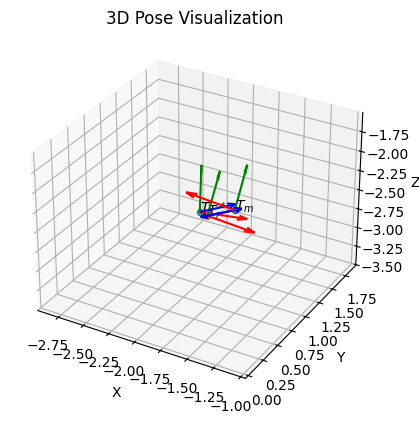

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
show_pose(ax, T_m, "$T_m$")
show_pose(ax, T_r_star, "${T_r}^{*}$")
show_pose(ax, T_r, "$T_r$")
plt.show()

In [ ]:
# check one step correctness
np.isclose(T_s @ T_c @ T_o @ pose_inv(T_r_star), np.eye(4))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

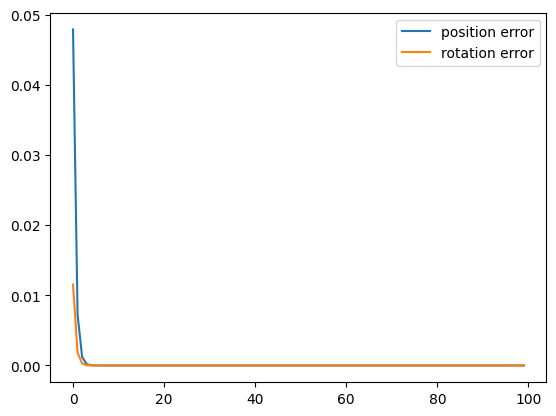

(np.float64(1.3911054626160788e-15), 1.6455836310913813e-16)

In [ ]:
T_r_list, T_o_list, T_s_list, err_p_list, err_r_list = algorithm(
    T_r, T_r_star, T_c, 100,
    T_m, 0.0, 0.0
)
get_smooth_errors(T_s_list, T_o_list, T_c, T_r_star)
plt.plot(err_p_list, label="position error")
plt.plot(err_r_list, label="rotation error")
plt.legend()
plt.show()
err_p_list[-1], err_r_list[-1]

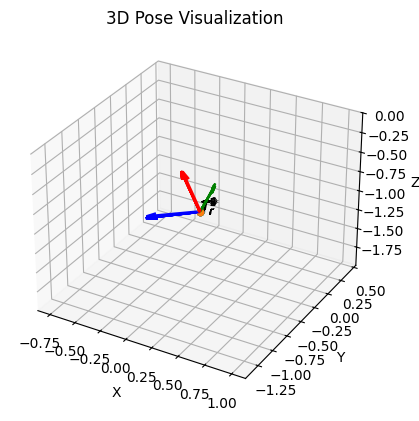

In [ ]:
|fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, _T_r in enumerate(T_r_list):
  show_pose(ax, _T_r, f"$T_r^{(i)}$")
show_pose(ax, T_r_star, "${T_r}^{*}$")
plt.show()

In [ ]:
np.isclose(T_r_list[-1] @ pose_inv(T_r_star), np.eye(4), rtol=0, atol=1e-4)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
hand_eye_param = np.array([0.00001, 0.075, 0.0449, 0, 0, 0, 1])
pbvs = PBVS(hand_eye_param, T_r, T_r_star, T_c, T_m, 0.0, 0.0)
poses, t_errs, r_errs = pbvs.loop()

pos = poses[:, :3].mean(axis=0)
quat = Rotation.from_quat(poses[:, 3:]).mean().as_quat()
pose = np.concatenate([pos, quat])
pbvs.set_position_techman(pose)
T_r_hat = T.convert_pose_quat2mat(pose) @ T.convert_pose_quat2mat(hand_eye_param) @ pbvs.get_changed_T_c()
diff = (T_r_hat @ T.pose_inv(T_r_star))
diff_r = Rotation.from_matrix(diff[:3, :3]).magnitude()
diff_p = np.linalg.norm(diff[:3, 3])
diff_p, np.degrees(diff_r)

(np.float64(0.0001861935087868944), np.float64(0.0006040451717479688))

In [ ]:
T_r_hat @ T.pose_inv(T_r_star)

(array([[ 0.99082084,  0.13285364, -0.02497951, -0.19687266],
        [-0.13016283,  0.98748902,  0.08901162,  0.01927379],
        [ 0.03649251, -0.08494316,  0.99571731,  0.15334757],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 9.87562379e-01, -1.40621648e-01,  7.03285117e-02,
          6.99044663e-04],
        [ 1.40246388e-01,  9.90063369e-01,  1.02701825e-02,
         -3.27944786e-02],
        [-7.10738932e-02, -2.79126151e-04,  9.97471014e-01,
         -1.06630962e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]))

In [ ]:
(T_r_hat @ T.pose_inv(T_r_star)).round(3)

array([[ 1.   , -0.   ,  0.   ,  0.001],
       [ 0.   ,  1.   ,  0.001,  0.002],
       [-0.   , -0.001,  1.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])